# Comparison of Modeled and Observed Atmospheric DMS and CHBr3 

### Prepare Workspace

In [128]:
import numpy as np
import xarray as xr
import pandas as pd 
import datetime 

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits import mplot3d
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline
%config inlinebackend.figure_format='retina'

### Define a few functions

In [129]:
# make functions we'll use 
# find index of value closest to desired value 
def find_nearest(desired, variable):
    diff = ([])
    for ll in variable:
        dd = np.absolute(desired - ll)
        diff.append(dd)
    ind = diff.index(min(diff))
    val = np.float(variable[ind])
    return ind

# convert hpa to km
# p = p0*exp(-z/H)
H = 10*1000 # km to m  
p0 = 100000 # Pa 
def hpa_to_km(hpa_in):
    m = np.log(hpa_in/p0)*-H
    km_out = m/1000
    return km_out

# and km to hpa 
def km_to_hpa(km_in):
    m = km_in*1000
    pa = p0*np.exp(-m/H)
    hpa_out = pa/100
    return hpa_out

### Load in Aircraft Data from the CONTRAST Field Campaign

In [130]:
! wget -O contrast_file 'https://docs.google.com/uc?export=download&id=1xVarpVV6Su5ophCqOpG14D4lHrF1xHBa'

/bin/sh: wget: command not found


In [131]:
# read in the file using xarray 
toga = xr.open_dataset('contrast_file')

# make a smaller more workable data set (we dont need all those variables)
toga = toga[['Time','GGLAT', 'GGLON', 'GGALT', 'DMS', 'Bromoform', 'CFC11']]
toga

<xarray.Dataset>
Dimensions:    (Time: 196)
Coordinates:
  * Time       (Time) datetime64[ns] 2014-02-12T23:59:25 ... 2014-02-13T06:29:25
Data variables:
    GGLAT      (Time) float32 ...
    GGLON      (Time) float32 ...
    GGALT      (Time) float32 ...
    DMS        (Time) float32 ...
    Bromoform  (Time) float32 ...
    CFC11      (Time) float32 ...
Attributes:
    Institution:                     NCAR Atmospheric Chemistry Observations ...
    Address:                         P.O. Box 3000, Boulder, CO 80307-3000
    Phone:                           (303) 497-8194
    Author:                          Shawn Honomichl
    Author_Email:                    shawnh@ucar.edu
    Nomenclature_compliance_note:    Spaces removed from variable names when ...
    Merged_NetCDF_Creation_Date:     Wed Aug 24 21:12:41 2016
    Project_Name:                    CONTRAST
    Aircraft_Type:                   GV
    Aircraft_Tail:                   N677F
    Flight:                          rf11
  

### Load in CAMchem model data

In [132]:
! wget -O camchem_file 'https://docs.google.com/uc?export=download&id=1XnQLD3iAt6ALa1D8P1GMZTmK1317ZPE8'

/bin/sh: wget: command not found


In [133]:
cam = xr.open_dataset('camchem_file')
cam = cam[['DMS', 'CHBR3']]*(1e12)
cam

<xarray.Dataset>
Dimensions:  (lat: 32, lev: 56, lon: 25, time: 1)
Coordinates:
  * lev      (lev) float64 1.868 2.353 2.948 3.677 ... 947.5 962.5 977.5 992.5
  * time     (time) object 2014-12-01 00:00:00
  * lon      (lon) float64 130.0 131.2 132.5 133.8 ... 156.2 157.5 158.8 160.0
  * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 26.86 27.8 28.74 29.69
Data variables:
    DMS      (time, lev, lat, lon) float32 4.1773454e-25 ... 14.167538
    CHBR3    (time, lev, lat, lon) float32 5.949005e-26 ... 1.6521943
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             f.e11.TS1IREFC1SD.f09.f09.ccmi34.Aircraft_2014-2016.cy.001
    title:            UNSET
    logname:          dkin
    host:             r1i4n16
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade2/scratch2/dkin/f.e11.TS1IREFC1SD.f09.f09.ccmi34....
    topography_file:  /glade/p/acd/tilmes/inputdata/topo/USGS-gtopo30_0.9x1.2...

### Study Area and Flight Path

Text(129, 14, 'Phillipines')

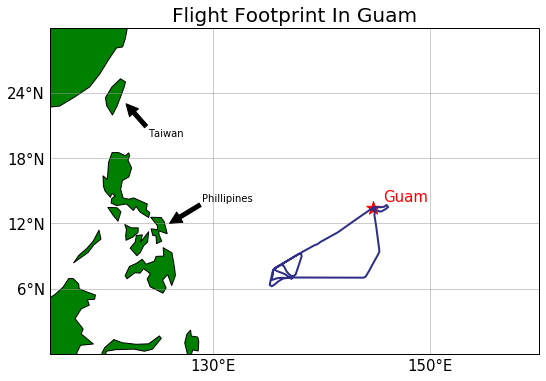

In [134]:
# ------------------------------------------- figure 0 -------------------------------------------
########## plot location 
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.plot(toga.GGLON, toga.GGLAT, c = [0.18, 0.18, 0.53], linewidth = 2)
ax.set_title('Flight Footprint In Guam', fontsize=20)

latmin = 0 
latmax = 30 
lonmin = 115 
lonmax = 160

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())
#ax.coastlines(resolution='50m', color='k', linewidth=1)
ax.add_feature(cf.LAND, facecolor = 'g', edgecolor = 'k')
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([lonmin, 130, 150, lonmax])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# add guam marker 
plt.scatter(144.7, 13.4, s = 200, c = 'r', marker = '*')
ax.text(144.7+3, 13.4+1, "Guam", c = 'r', ha="center", va="center", size=15)

# add some arrows 
ax.annotate('Taiwan', xy=(122, 23),
             xytext=(124, 20), arrowprops={'facecolor': 'k'})
ax.annotate('Phillipines', xy=(126, 12),
             xytext=(129, 14), arrowprops={'facecolor': 'k'})

Text(147.7, 11.4, 'Guam')

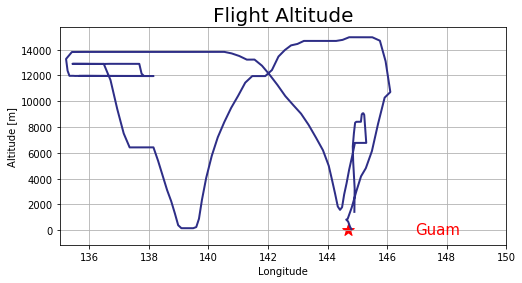

In [135]:
########## plot vertical
fig, ax = plt.subplots(figsize = (8, 4))

plt.plot(toga.GGLON, toga.GGALT, c = [0.18, 0.18, 0.53], linewidth = 2)
ax.set_title('Flight Altitude', fontsize=20)

ax.set_xlim([135, 150])
ax.set_xlabel('Longitude')
ax.set_ylabel('Altitude [m]')

ax.grid(which = 'major')

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'r', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'r', ha="center", va="center", size=15)

### 3D Plots of Flight Data

Text(14, 142, 'Guam')

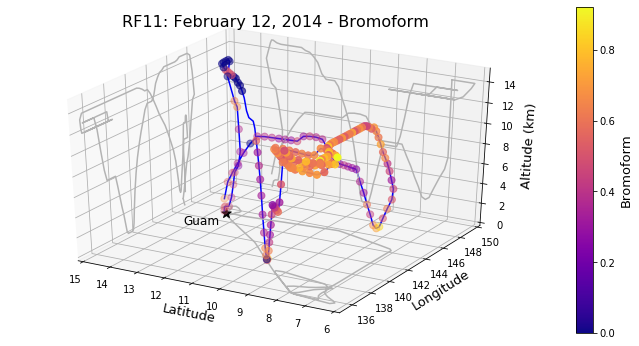

In [136]:
# ------------------------------------------- figure 1 -------------------------------------------
# Bromoform along flight track 
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

# axis limits
maxx = toga.Bromoform.max()
minn = toga.Bromoform.min()

# plot 
ax.set_title('RF11: February 12, 2014 - Bromoform', fontsize = 16)
a = ax.plot(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c='b')
a = ax.scatter3D(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c=toga.Bromoform, 
                 s = 50, cmap='plasma', vmin = 0, vmax = maxx)
ax.set_xlabel('Latitude', fontsize = 13)
ax.set_xlim([15,6])
ax.set_ylabel('Longitude', fontsize = 13)
ax.set_ylim([135, 150])
ax.set_zlabel('Altitude (km)', fontsize = 13);
ax.set_zlim([0, 15])

# colorbar 
cbar = fig.colorbar(a)
cbar.set_label('Bromoform', fontsize = 13)

# add gray lines 
flat1 = np.zeros_like(toga.GGALT/1000)
ax.plot3D(toga.GGLAT, toga.GGLON, flat1, c=[0.7, 0.7, 0.7])
flat2 = np.full_like(toga.GGLAT, 15)
ax.plot3D(flat2, toga.GGLON, toga.GGALT/1000, c=[0.7, 0.7, 0.7])
flat3 = np.full_like(toga.GGLON, 150)
ax.plot(toga.GGLAT, flat3, toga.GGALT/1000, c=[0.7, 0.7, 0.7])

# add guam pointer 
ax.scatter(13.4, 144.8, marker = '*', color = 'k', s = 100)
ax.text(14, 142, 0, s='Guam', fontsize=12)

Text(14, 142, 'Guam')

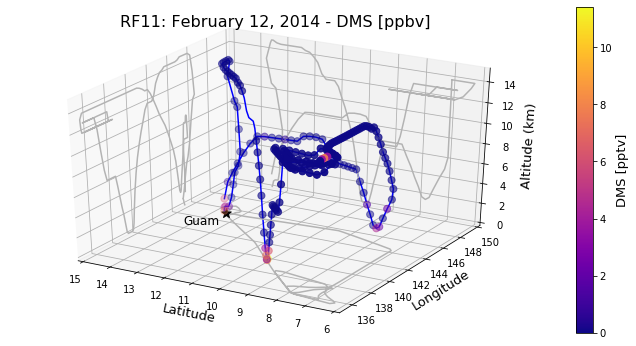

In [137]:
# ------------------------------------------- figure 2 -------------------------------------------
# DMS along flight track 
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

# axis limits
maxx = toga.DMS.max()
minn = toga.DMS.min()

# plot 
ax.set_title('RF11: February 12, 2014 - DMS [ppbv]', fontsize = 16)
a = ax.plot(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c='b')
a = ax.scatter3D(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c=toga.DMS, 
                 s = 50, cmap='plasma', vmin = 0, vmax = maxx)
ax.set_xlabel('Latitude', fontsize = 13)
ax.set_xlim([15,6])
ax.set_ylabel('Longitude', fontsize = 13)
ax.set_ylim([135, 150])
ax.set_zlabel('Altitude (km)', fontsize = 13);
ax.set_zlim([0, 15])

# colorbar 
cbar = fig.colorbar(a)
cbar.set_label('DMS [pptv]', fontsize = 13)

# add gray lines 
flat1 = np.zeros_like(toga.GGALT/1000)
ax.plot3D(toga.GGLAT, toga.GGLON, flat1, c=[0.7, 0.7, 0.7])
flat2 = np.full_like(toga.GGLAT, 15)
ax.plot3D(flat2, toga.GGLON, toga.GGALT/1000, c=[0.7, 0.7, 0.7])
flat3 = np.full_like(toga.GGLON, 150)
ax.plot(toga.GGLAT, flat3, toga.GGALT/1000, c=[0.7, 0.7, 0.7])

# add guam pointer 
ax.scatter(13.4, 144.8, marker = '*', color = 'k', s = 100)
ax.text(14, 142, 0, s='Guam', fontsize=12)

### CAMchem Data

Text(147.7, 11.4, 'Guam')

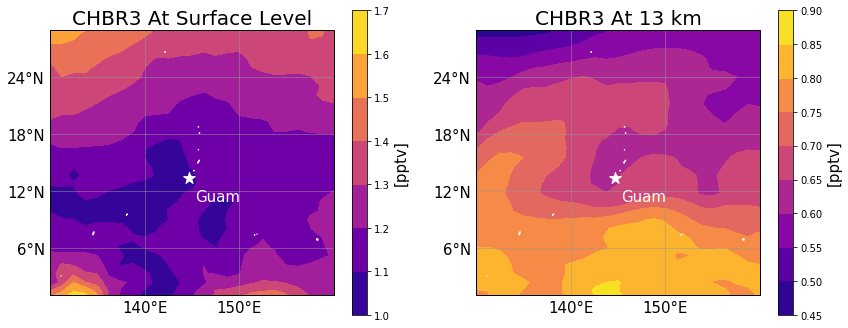

In [138]:
# ------------------------------------------- figure 3 -------------------------------------------
# plot camchem at surface level and at 11 km - CHBR3 
# test plot 
fig = plt.figure(figsize=(14, 8))

# ------------------------- Near Surface 
# surface
surf = find_nearest(km_to_hpa(1), cam['lev'])

# plot 
ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
chbr3_surf = cam['CHBR3'].isel(lev = surf).squeeze()
plt.contourf(chbr3_surf.lon, chbr3_surf.lat, chbr3_surf, cmap = 'plasma')
ax.set_title('CHBR3 At Surface Level', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


# ------------------------- Near UT 
# 10 km
ut = find_nearest(km_to_hpa(13), cam['lev'])

# plot 
ax = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
chbr3_ut = cam['CHBR3'].isel(lev = ut).squeeze()
plt.contourf(chbr3_ut.lon, chbr3_ut.lat, chbr3_ut, cmap = 'plasma')
ax.set_title('CHBR3 At 13 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


Text(147.7, 11.4, 'Guam')

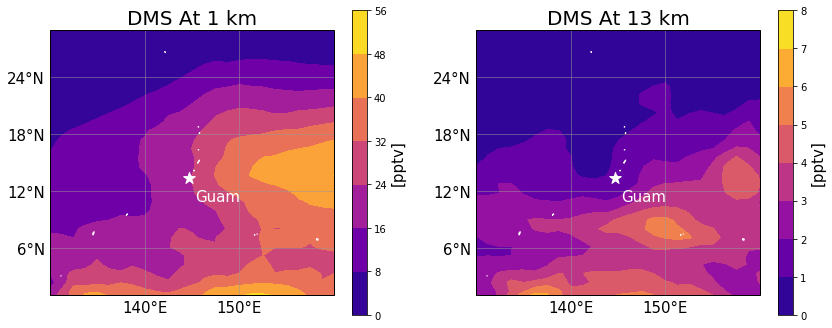

In [141]:
# ------------------------------------------- figure 4 -------------------------------------------
# plot camchem at surface level and at 11 km - DMS 
# test plot 
fig = plt.figure(figsize=(14, 8))

# ------------------------- Near Surface 
# surface
surf = find_nearest(km_to_hpa(1), cam['lev'])

# plot 
ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
DMS_surf = cam['DMS'].isel(lev = surf).squeeze()
plt.contourf(DMS_surf.lon, DMS_surf.lat, DMS_surf, cmap = 'plasma')
ax.set_title('DMS At 1 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


# ------------------------- Near UT 
# 13 km 
ut = find_nearest(km_to_hpa(13), cam['lev'])

# plot 
ax = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
DMS_ut = cam['DMS'].isel(lev = ut).squeeze()
plt.contourf(DMS_ut.lon, DMS_ut.lat, DMS_ut, cmap = 'plasma')
ax.set_title('DMS At 13 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


### Statistical Comparison 

Text(0.2, 4.2, '2400 CAMchem Samples')

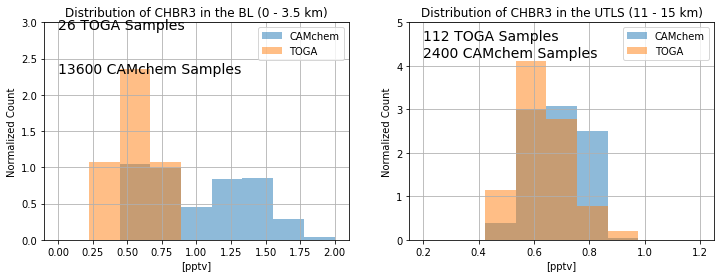

In [189]:
# ------------------------------------------- figure 5 -------------------------------------------
# CHBR3 comparison in boundary layer (BL) and upper troposphere lower stratosphere (UTLS) 

# ------------------------ BL 
# camchem values near surface 
bltop = km_to_hpa(3.5)
cam_chbr3_bl = cam['CHBR3'].sel(lev = slice(bltop,1000)).values.flatten()
# toga values near surface
toga_chbr3_bl = toga.Bromoform[np.where(toga.GGALT < 3500)]

# plot 
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

bins = np.linspace(0, 2, 10)
ax[0].hist(cam_chbr3_bl, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[0].hist(toga_chbr3_bl, bins, alpha=0.5, density = True, label = 'TOGA')

ax[0].grid(which = 'major')
ax[0].set_title ('Distribution of CHBR3 in the BL (0 - 3.5 km)')
ax[0].set_xlabel('[pptv]')
ax[0].set_ylabel('Normalized Count')
ax[0].legend()

ax[0].set_ylim(0, 3)

# annotate 
ax[0].annotate(str(len(toga_chbr3_bl))+' TOGA Samples', xy=(0, 2.9), 
              fontsize = 14)
ax[0].annotate(str(len(cam_chbr3_bl))+' CAMchem Samples', xy=(0, 2.3), 
              fontsize = 14)

# ------------------------ UT
uttop = km_to_hpa(15)
utbottom = km_to_hpa(11)
# camchem values in upper tropo 
cam_chbr3_ut = cam['CHBR3'].sel(lev = slice(uttop,utbottom)).values.flatten()
# toga values near surface
toga_chbr3_ut = toga.Bromoform[np.where(toga.GGALT > 11000)]

# plot 
bins = np.linspace(0.2, 1.2, 10)
ax[1].hist(cam_chbr3_ut, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[1].hist(toga_chbr3_ut, bins, alpha=0.5, density = True, label = 'TOGA')

ax[1].grid(which = 'major')
ax[1].set_title ('Distribution of CHBR3 in the UTLS (11 - 15 km)')
ax[1].set_xlabel('[pptv]')
ax[1].set_ylabel('Normalized Count')
ax[1].legend()

ax[1].set_ylim(0, 5)

# annotate 
ax[1].annotate(str(len(toga_chbr3_ut))+' TOGA Samples', xy=(0.2, 4.6), 
              fontsize = 14)
ax[1].annotate(str(len(cam_chbr3_ut))+' CAMchem Samples', xy=(0.2, 4.2), 
              fontsize = 14)

Text(0, 0.63, '2400 CAMchem Samples')

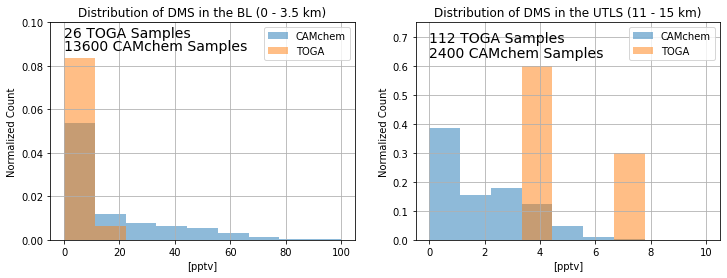

In [184]:
# ------------------------------------------- figure 6 -------------------------------------------
# DMS comparison in boundary layer (BL) and upper troposphere lower stratosphere (UTLS) 

# ------------------------ BL 
# camchem values near surface 
cam_dms_bl = cam['DMS'].sel(lev = slice(bltop,1000)).values.flatten()
# toga values near surface
toga_dms_bl = toga.DMS[np.where(toga.GGALT < 3500)]

# plot 
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

bins = np.linspace(0, 100, 10)
ax[0].hist(cam_dms_bl, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[0].hist(toga_dms_bl, bins, alpha=0.5, density = True, label = 'TOGA')

ax[0].grid(which = 'major')
ax[0].set_title ('Distribution of DMS in the BL (0 - 3.5 km)')
ax[0].set_xlabel('[pptv]')
ax[0].set_ylabel('Normalized Count')
ax[0].legend()

ax[0].set_ylim(0, 0.1)

# annotate
ax[0].annotate(str(len(toga_dms_bl))+' TOGA Samples', xy=(0, 0.093), 
              fontsize = 14)
ax[0].annotate(str(len(cam_dms_bl))+' CAMchem Samples', xy=(0, 0.087), 
              fontsize = 14)

# ------------------------ UT
uttop = km_to_hpa(15)
utbottom = km_to_hpa(11)
# camchem values in upper tropo 
cam_dms_ut = cam['DMS'].sel(lev = slice(uttop,utbottom)).values.flatten()
# toga values near surface
toga_dms_ut = toga.DMS[np.where(toga.GGALT > 11000)]

# plot 
bins = np.linspace(0, 10, 10)
ax[1].hist(cam_dms_ut, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[1].hist(toga_dms_ut, bins, alpha=0.5, density = True, label = 'TOGA')

ax[1].grid(which = 'major')
ax[1].set_title ('Distribution of DMS in the UTLS (11 - 15 km)')
ax[1].set_xlabel('[pptv]')
ax[1].set_ylabel('Normalized Count')
ax[1].legend()

ax[1].set_ylim(0, 0.75)

# annotate 
ax[1].annotate(str(len(toga_dms_ut))+' TOGA Samples', xy=(0, 0.68), 
              fontsize = 14)
ax[1].annotate(str(len(cam_dms_ut))+' CAMchem Samples', xy=(0, 0.63), 
              fontsize = 14)


### Rough Point to Point Comparison

In [119]:
# ------------------------------------------- figure 7 -------------------------------------------
# isolate each toga point lat and lon 
toga_time = []
time_steps = []
for i in range(0, len(toga.Time)):
    if (np.isnan(toga.GGALT.values[i]) == False):
        toga_time.append(toga.Time[i])
        time_steps.append(i)
        
# match each toga point to a camchem profile (1 x 56 levels)
cam_dms_points = np.zeros((len(time_steps), len(cam.lev)))
cam_chbr3_points = np.zeros((len(time_steps), len(cam.lev)))

for i in range(0, len(toga.Time)):
    if (np.isnan(toga.GGALT.values[i]) == False):
        cam_dms_points[i,:] = cam['DMS'].sel(lat = toga.GGLAT.values[i], method='nearest').sel(lon = toga.GGLON.values[i], method='nearest')
        cam_chbr3_points[i,:] = cam['CHBR3'].sel(lat = toga.GGLAT.values[i], method='nearest').sel(lon = toga.GGLON.values[i], method='nearest')
        

In [120]:
# convert toga height in meters to pressure 
toga_hpa = []
for i in toga.GGALT[:-3].values:
    toga_hpa.append(((1000*100)*np.exp(-i/(10*1000)))/100)

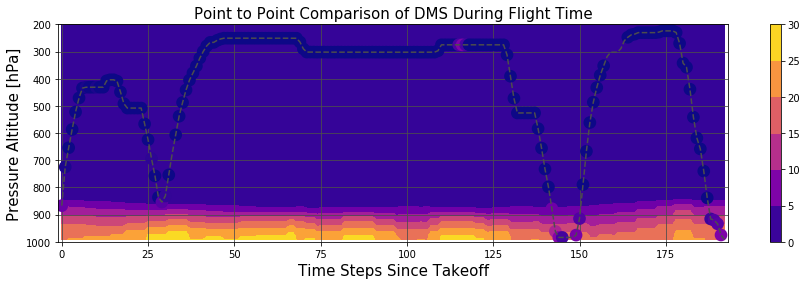

In [121]:
# plot camchem - CHBR3
fig, ax = plt.subplots(figsize=(15, 4))

# limits of colorbar
cminn = 0
cmaxx = 30

# contour
p0 = ax.contourf(time_steps, cam.lev, np.transpose(cam_dms_points), cmap = 'plasma')
plt.xlabel('Time Steps Since Takeoff', fontsize=15)
plt.ylabel('Pressure Altitude [hPa]', fontsize=15)
plt.title('Point to Point Comparison of DMS During Flight Time', fontsize=15)
plt.grid(which='major', linestyle='-', color = '0.3')

ax.set_ylim([1000, 200])
ax.set_xlim([-1, len(time_steps)])

# add toga 
ax.plot(time_steps, toga_hpa, linestyle = '--', color = '0.3', zorder = 3)
ax.scatter(time_steps, toga_hpa, c = toga.DMS[:-3], cmap = 'plasma',
            vmin = cminn, vmax = cmaxx, marker='o', s=75, linewidths=4, zorder = 2)

# colorbar
m = plt.cm.ScalarMappable(cmap='plasma')
m.set_array(cam_dms_points)
m.set_clim(cminn, cmaxx)
plt.colorbar(m, boundaries=np.arange(cminn, cmaxx+5, 5))

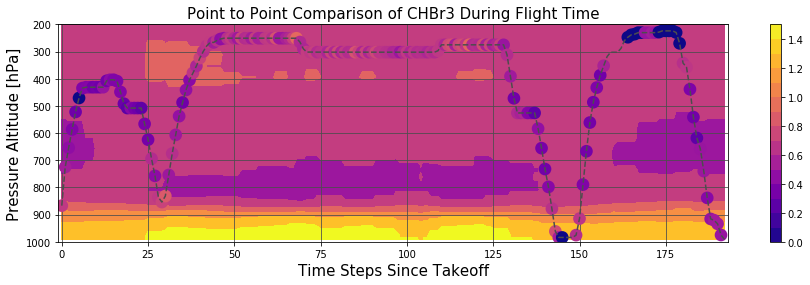

In [122]:
# plot camchem - CHBR3
fig, ax = plt.subplots(figsize=(15, 4))

# limits of colorbar
cminn = 0
cmaxx = 1.5

# contour
p0 = ax.contourf(time_steps, cam.lev, np.transpose(cam_chbr3_points), cmap = 'plasma', 
           vmin = cminn, vmax = cmaxx)
plt.xlabel('Time Steps Since Takeoff', fontsize=15)
plt.ylabel('Pressure Altitude [hPa]', fontsize=15)
plt.title('Point to Point Comparison of CHBr3 During Flight Time', fontsize=15)
plt.grid(which='major', linestyle='-', color = '0.3')

ax.set_ylim([1000, 200])
ax.set_xlim([-1, len(time_steps)])

# add toga 
ax.plot(time_steps, toga_hpa, linestyle = '--', color = '0.3', zorder = 3)
ax.scatter(time_steps, toga_hpa, c = toga.Bromoform[:-3], cmap = 'plasma',
            vmin = cminn, vmax = cmaxx, marker='o', s=75, linewidths=4, zorder = 2)

# colorbar
m = plt.cm.ScalarMappable(cmap='plasma')
m.set_array(cam_chbr3_points)
m.set_clim(cminn, cmaxx)
plt.colorbar(m, boundaries=np.arange(cminn, cmaxx+0.1, 0.1))

## Some Concusions 

There is decent agreement between the modeled and observed data in terms of general and relative distribution (i.e. maximum concentration near the surface, diminishing out of the boundary layer) but some pretty large discrepancies in magnitude. CAMchem consistently shows mixing ratios much higher than observed by the flight data. 

Bromoform has a much better agreement than DMS. Overall bromoform's distribution is fairly comprable between the two data sets, With the largest difference being in the scale of boundary layer concentrations. This is likely due to the model's boundary layer conditions which may not estimate surface fluxes properly. 

DMS does not have great agreement. The surface values are vastly different, with outliers >100 ppt for CAMchem. Maximum observed values are all < 20 ppt. 

The DMS enhacements in the UT observations are not present in the model. This is likely due to the extremely short lifetime of DMS (~1 day) and the model struggling to properly represent its transport via strong convective updrafts. These features are parameterized rather than explicityly resolved, and so chemical transport via these pathways is typically not well represented in GCMs. This mostly affects very short lived species such as DMS. Also, detection limits of the trace gas prohibit very low mixing ratio samples skewing the UT distribution of observed samples. 

Some caveats to this simple analysis are: 

1) We are only using one day of flight data, which is far too small a dataset to truly compare the two. For example, our histograms are only ~20 - 100 TOGA samples vs. thousands of CAMchem samples. Ideally this would be a lot more robust using a lot more data than just one flight. 

2) The point to point comparison is only a simple nearest-point analysis. Ideally, the two data sets would be interpolated. 